In [4]:
import sys 
import os
import os.path as osp 
from os import listdir

""" Path checking 
"""
python_ver = sys.version
print( os.getcwd())

c:\Users\camin\PhD_DB\workspace_math\Math-Programming-for-Coders\Math-Tools-for-DS\01_Covariance_Matrix


In [6]:
import numpy as np 
from numpy import linalg as LA  # linear algebra; (ref) https://wikidocs.net/15655
import matplotlib.pyplot as plt

In [7]:
# %% Reproducibility
np.random.seed(20150927)


In [8]:
# data loading helper functions 

def extract_temp(file_name,col_ind):
    data_aux = np.loadtxt(file_name, usecols=range(10))
    data = data_aux[:,col_ind]
    err_count = 0
    ind_errs = []
    for ind in range(data.shape[0]):
        if data[ind] > 100 or data[ind] < -100:
            err_count = err_count + 1
            ind_errs.append(ind)
            data[ind] = data[ind-1]  
    print( "File name: " + file_name)
    print( "Errors: " + str(err_count) + " Indices: " + str(ind_errs))
    return data

def create_data_matrix(str_path):
    file_name_list = listdir(str_path)
    file_name_list.sort()
    col_ind = 8 # 8 = last 5 minutes, 9 = average over the whole hour
    data_matrix = []
    ind = 0
    for file_name in file_name_list:
        if file_name[0] == '.':
            continue
        else:
            print("Station " + str(ind))
            ind = ind + 1
            data_aux = extract_temp(str_path + file_name,col_ind)
            if len(data_matrix) == 0:
                data_matrix = data_aux
            else:
                data_matrix = np.vstack((data_matrix,data_aux))
    return data_matrix.T

def running_mean(x):
    l = 24
    return np.convolve(x, np.ones(l)/l, mode='valid')

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]



In [9]:
data_path = osp.join(os.getcwd(), 'DB', 'weather')
load_files = False #either read through all csvs files or just load the precomputed npy file

if load_files:
    str_path_2015 = osp.join(data_path , 'hourly', '2015')
    data_matrix = create_data_matrix(str_path_2015)
    str_path_2016 = osp.join(data_path , "hourly", "2016")
    data_matrix_2016 = create_data_matrix(str_path_2016)
else:
    data_matrix = np.load(osp.join(data_path , "hourly_temperature_2015.npy"))
    data_matrix_2016 = np.load(osp.join(data_path , "hourly_temperature_2016.npy"))    
file_name_list = listdir(osp.join(data_path , "hourly", "2015"))
file_name_list.sort()    

print(data_matrix.shape)  

(8760, 134)


In [10]:
""" Compute centered data matrix, 
    covariance matrix and correlation matrix
"""
mean = np.mean(data_matrix,axis=0)
data_matrix_centered = data_matrix - mean
cov_matrix = np.cov(data_matrix.T)
# cov_matrix_sanity_check = data_matrix_centered.T @ data_matrix_centered / dat_matrix_centered.shape[0]
corr_matrix = np.corrcoef(data_matrix.T)
print(cov_matrix.shape)

(134, 134)


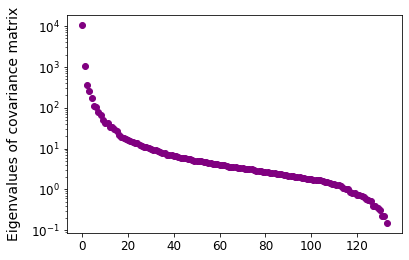

In [11]:
pc_vars, pds = LA.eig(cov_matrix)

plt.figure()
plt.semilogy(np.sort(pc_vars)[::-1],linestyle="None",marker='o',color='purple')
plt.ylabel('Eigenvalues of covariance matrix',fontsize=14,labelpad=10)
plt.tick_params(labelsize=12)

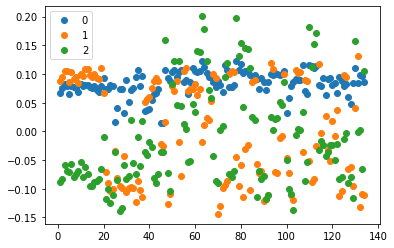

In [12]:
r = 3

plt.figure()
for ind in range(r): 
    plt.plot(np.arange(1,data_matrix_centered.shape[1]+1),pds[:,ind],'o',label=str(ind))
plt.legend()

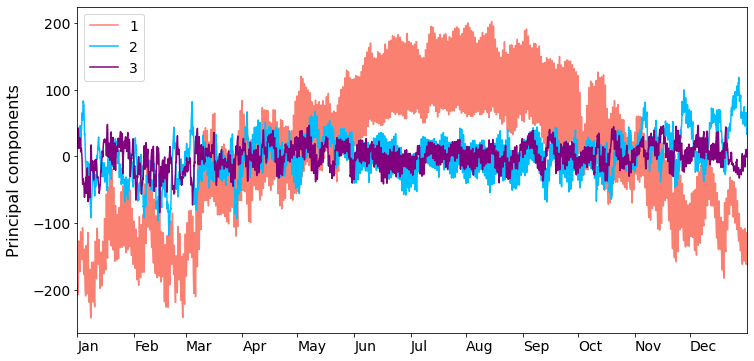

In [13]:
""" Principal Components 
"""

pcs = np.zeros((data_matrix_centered.shape[0],r))
for ind in range(r):
    pcs[:,ind] = data_matrix_centered @ pds[:,ind]
    
plt.figure(figsize=(12,6))
colors = ['salmon','deepskyblue','purple']
for ind in range(r): 
    plt.plot(pcs[:,ind],label=str(ind+1),color=colors[ind])
    
plt.legend(fontsize=14)
plt.ylabel('Principal components',fontsize=16,labelpad=10)
xtick_labels = ['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
xtick_vals = 24*np.cumsum(np.array([0,31,28,31,30,31,31,30,31,30,31,30]))
plt.xticks(xtick_vals, xtick_labels)
plt.tick_params(labelsize=14)
plt.xlim([0,data_matrix_centered.shape[0]])
ax = plt.gca()
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")